# Vector Data in Python with Geopandas

As noted in our introductory reading, GIS data comes in two flavors -- vector data and raster data -- and in this reading, we'll be learning about the main package for working with vector geospatial data: Geopandas!

Like most tabular data we work with, geospatial vector data generally comes to us in the form of a table where each row constitutes a single observation, and each column constitutes a different variable. Unlike regular tabular data, however, each observation in vector data also contains information relating the observation to a location in the world. 

The term "vector data" comes from the fact that observations are linked to locations in the world by associating each observation with a geometric object -- a point, line, polygon -- and each of these geometric shapes is represented by a series of vertices (x-y coordinates) connected by straight lines. For example, we can represent this square:

![Unit Square](https://upload.wikimedia.org/wikipedia/commons/7/71/Unit_Square.svg)

with a vector consisting of the x-y coordinates of the corners of the square (the square's *vertices*): `[(0, 0), (1, 0), (1, 1), (0, 1)]` (image source: [Wikipedia](https://en.wikipedia.org/wiki/Unit_square#/media/File:Unit_Square.svg)).

The ability to represent the relationship between units of observation and locations on earth using these geometric shapes is extremely powerful. For example, we can use points to represent the locations of singular objects (e.g. stores, customers, cellphone towers, etc.), but we can also use lines to represent roads or rivers, and we can use polygons to represent units of observations that cover a specific area, such as countries, media markets, census blocks, etc. 

Moreover, as we'll see later, because these shapes are all represented using collections of coordinates in a two-dimensional plane, these different geometric shapes can interact easily. For example, it's easy to do things like a "spatial join" where we pull all the rows in one dataset that have customers (represented by points) that are physically located inside a media market (represented by a polygon) in another dataset based only on their spatial relationship to one another.

### Wait, Only Two Dimensions?

At this point, some careful readers may be saying to themselves: "Uh... hey: how are we just storing the vertices of these shapes as x-y coordinates? The world isn't flat, so how are we representing everything in two dimensions?"

Great question careful reader! The short answer is that when working with GIS data, we almost always treat our data as two-dimensional because we can employ some tricks to *project* locations on the round Earth into a two-dimensional plane, and working in two-dimensions is *much* easier than working in three. We'll talk a lot more about how this is done (because there are a lot of important nuances in how we choose to project locations onto a two-dimensional plane), but for the moment, it's enough to know that we can do it! 

Indeed, you're almost surely already familiar with one trick we use to do this: latitude and longitude coordinates! Every location on the surface of the Earth can be identified by specifying a latitude and longitude, which are (in effect) just x-y coordinates.

So for the moment, if thinking about coordinates in two dimensions feels odd, just think of these coordinates as latitudes and longitudes. 

As mentioned in our [last reading](gis_what_is_gis.ipynb), though, and as we'll discuss in detail in a later reading, we definitely aren't limited to latitude and longitude -- indeed, the tools we're using can be used for any representation of locations in two dimensions, like locations in a warehouse or on a football field!

## Geopandas

Because vector spatial data is essentially just regular tabular data + a geometric shape associated with each row, in this course we will be using a library called Geopandas that, as the name implies, is based on Pandas. In effect, Geopandas represents vector spatial data as a pandas DataFrame that includes an object column that contains the geometric shape associated with each row (something it calls a GeoDataFrame)! To illustrate, here's the GeoDataFrame of all the countries in the world we saw in the last reading:

In [1]:
import geopandas as gpd
import numpy as np

# Load GIS data
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Look at the data
world.sample(5)

pop_est      continent              name iso_a3  gdp_md_est  \
150   1972126         Europe          Slovenia    SVN     68350.0   
7     6909701        Oceania  Papua New Guinea    PNG     28020.0   
30   11138234  South America           Bolivia    BOL     78350.0   
53    3758571         Africa        Mauritania    MRT     16710.0   
81   11403800         Africa           Tunisia    TUN    130800.0   

                                              geometry  
150  POLYGON ((13.80648 46.50931, 14.63247 46.43182...  
7    MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...  
30   POLYGON ((-69.52968 -10.95173, -68.78616 -11.0...  
53   POLYGON ((-17.06342 20.99975, -16.84519 21.333...  
81   POLYGON ((9.48214 30.30756, 9.05560 32.10269, ...

<AxesSubplot:>

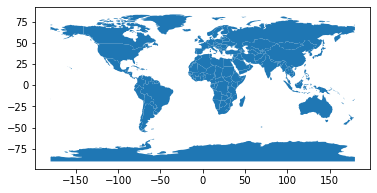

In [2]:
world.plot()

Crucially, this means that GeoDataFrames support all the operations you're familiar with from pandas, including merging, subsetting, etc. In fact, geopandas isn't just based on Pandas in an abstract sense -- the way geopandas is written is by "inheriting" the DataFrame object from pandas then adding to it. So as soon as something changes in pandas, those changes will propagate to geopandas as well. 

(Honestly, this may be one of the only instances I've ever seen of the inheritance idea from object-oriented programming actually working incredibly well).

To illustrate:

<AxesSubplot:>

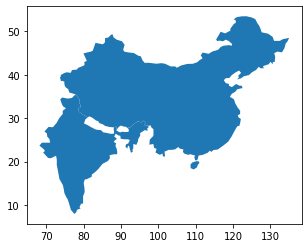

In [3]:
# Get countries whose population is at least 10x the 
# average county population
big_countries = world[world.pop_est > world.pop_est.mean() * 10]

# And plot the subsets
big_countries.plot()

China and India! Great. 

Also, note the axes -- as noted above, one example of how we represent spatial data in two dimensions is by making our x-y coordinates equal to latitudes and longitudes, and that's precisely the representation being used by this data. Indeed, if we try to look at the actual shape object for a single country (say, India, which is located between 70 and 100 degrees Longitude (x-coordinate) and between 10 and 40 degrees of Latitude (y-coordinate)), we can see India is represented by a `POLYGON` object whose vertices all have values in that range, as we'd expect:

In [4]:
world.loc[world.name == "India", "geometry"]

98    POLYGON ((97.32711 28.26158, 97.40256 27.88254...
Name: geometry, dtype: geometry

### OK, so what makes Geopandas different?

Geopandas is *basically* just pandas with a column for spatial data, but that's not *all* it is. It also includes the following features we'll explore below:

- **Reading and Writing Spatial Data:** Spatial data has a number of standard data formats (shapefiles, geojson, etc.), and geopandas provides tools for reading and writing to all these formats (yay!).
- **Measuring Spatial Relationships:** Geopandas is deeply integrated with libraries for geometric manipulations, making it easy to do things like measure the distances between points in your data (say, to see if your sales people are spread out efficiently). And as mentioned before, one great uses of GIS is to link records from different databases based on locality -- say, pulling the records of all census blocks within a mile of where you might be adding a new store.
- **Projection Management:** A geodataframe includes an attribute (the Coordinate Reference System, or CRS) that keeps track of the projection used to convert locations on the Earth into the x-y coordinates in the shape objects (which are just floating point numbers). In the case of the `world` geodataframe we saw above, for example, the geodataframe's CRS just says "hey, the x-y coordinates used here are latitude and longitudes". So your geodataframe stores this information, and provides some tools for moving from one projection to another. 
- **Mapping:** As you've already seen, geopandas makes simple maps easy to generate.
- **Tools for Geometric Manipulations:** The utility of these tools are a little tricky to explain at this point, but geopandas has tools for doing things like taking points and expanding them into circles of a given diameter, or intersecting polygons.

So while geopandas is great in that it should feel very familiar, don't be fooled into thinking it doesn't also have a lot of extra skills to offer. 

(Note: all these abilities are rooted in other libraries that geopandas integrates into a single tool, so if you start reading about GIS in Python, you're likely to come across references to libraries like Shapely, PyGEOS, fiona, pyproj, etc. Those aren't really "alternatives", but rather libraries that can be used independently, but which are integrated into geopandas.)


## The Geometry Column

One key organizing concept for a GeoDataFrame is that it only ever has one active "geometry" column -- that is, a column with geometric objects that are used when doing spatial operations. By default, this column is named `geometry`, but that need not be the case -- the column that 

## Relating Data Sets

Like regular pandas DataFrames, GeoDataFrames can be merged with one another based on common merging variables. *Unlike* regular DataFrames, however, GeoDataFrames can also be merged based on spatial relationships using *spatial joins* with `sjoin`. 

To illustrate, let's being with two datasets: the dataset of countries we've been playing with already, and a dataset of cities:

<AxesSubplot:>

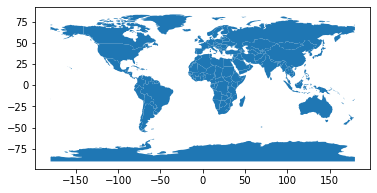

In [13]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot()

In [15]:
world.sample(3)

pop_est continent       name iso_a3  gdp_md_est  \
98   1281935911      Asia      India    IND   8721000.0   
71     19196246    Africa     Malawi    MWI     21200.0   
137    23232413   Oceania  Australia    AUS   1189000.0   

                                              geometry  
98   POLYGON ((97.32711 28.26158, 97.40256 27.88254...  
71   POLYGON ((32.75938 -9.23060, 33.73972 -9.41715...  
137  MULTIPOLYGON (((147.68926 -40.80826, 148.28907...

<AxesSubplot:>

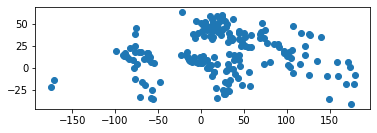

In [9]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities.plot()

In [14]:
cities.sample(5)

name                    geometry
79          Quito  POINT (-78.50200 -0.21304)
71          Abuja     POINT (7.53138 9.08528)
143     Pyongyang  POINT (125.75274 39.02138)
106        Bangui    POINT (18.55829 4.36664)
100  Yamoussoukro    POINT (-5.27550 6.81838)

In this toy city dataset, you will notice that we have cities' names, but not the country in which they are located. Since we know this variable is in our `world` dataset, we can do a spatial join to match each city observation up with the country in which it is located:

In [20]:
cities_w_county = cities.sjoin(world, how="left", predicate='intersects')
cities_w_county.sample(3)

name_left                   geometry  index_right      pop_est continent  \
71      Abuja    POINT (7.53138 9.08528)         56.0  190632261.0    Africa   
20       Bern   POINT (7.46698 46.91668)        127.0    8236303.0    Europe   
140  Khartoum  POINT (32.53223 15.59002)         14.0   37345935.0    Africa   

      name_right iso_a3  gdp_md_est  
71       Nigeria    NGA   1089000.0  
20   Switzerland    CHE    496300.0  
140        Sudan    SDN    176300.0

Voil√°! Just like that we've merged two datasets that have no variables in common. Note that like our regular merge/join methods, we can use `how` to dictate which rows we keep. Unlike merge/join, we also have an argument `predicate` which dictates what spatial relationships should be merged -- when merging points with polygons, there aren't a lot of ways you can imagine rows relating to one another, but when doing spatial joins of lines with polygons (say, matching roads with the states they cross), or polygons with polygons (matching media markets to states), you can imagine more complicated relationships. As such, `predicate` accepts:

- intersects
- contains
- within
- touches
- crosses
- overlaps

### Order of Join

Note that while normal merge/join are symmetric -- it doesn't really matter which is the right dataset and which is left -- it does matter for spatial joins, and only the *geometry* of one dataset is preserved. So if we do `cities.sjoin(world)`, the resulting geodataframe will be points (as above), but if we flip it, we end up with country polygons:

<AxesSubplot:>

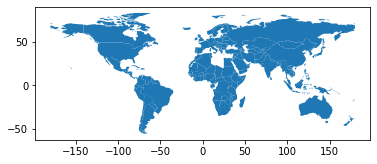

In [27]:
world.sjoin(cities).plot()

### Nearest Spatial Join

In addition to these intersecting/overlapping/containing spatial relationships, geopandas will also do spatial joins based on proximity with `sjoin_nearest`. To illustrate, let's find each city's closest neighbor:

(Note we'll get an error here telling us we shouldn't be calculating distances using a "geographic CRS". As with the area calculation in our [first reading](gis_what_is_gis.ipynb), its telling us something important, but something we won't discuss till our [reading on projections](gis_projections_and_crs.ipynb). MIDS students, I'll make you read that next -- if you're just coming to this through google, *please* be sure to read that after this!). 

In [21]:
nearest_pairs = cities.sjoin_nearest(cities, how="inner")
nearest_pairs.sample(3)

/Users/Nick/opt/miniconda3/lib/python3.9/site-packages/geopandas/array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


name_left                   geometry  index_right name_right
16   Ljubljana  POINT (14.51497 46.05529)           16  Ljubljana
158   Brussels   POINT (4.33137 50.83526)          158   Brussels
159      Dhaka  POINT (90.40663 23.72501)          159      Dhaka

In [25]:
gpd.datasets.nybb

AttributeError: module 'geopandas.datasets' has no attribute 'nybb'

## Geometric Manipulations